
## Research Question 
### What is the difference between separate models and multi-tasks learning model? 
### which performs better for all the tasks? 
### what are their advantages and disadvantages ?

## Experiment Details

This experiment uses one dimensional 2 features to predict the dialect. The features are:
### mfcc(40),mel<br>

The features extraction function is as follows:
    
### features = extract_feature(wav_file, mfcc=True,  mel=True, nhop=nhop)
For more details, please refer to the feature_extract function. Donot be overwhelmed by the feature extraction function. The function is just a wrapper of all possible features that can be combined and explored. 



## Experiment Results 
### Separate models perfom better than multi-task learning for the same architecture and parameters. For the sake of fair comparsion, everything is same except that separate models train the MLP model separately for three tasks, while multi-task learning trained and predict the three tasks at the same time. 

- Rong Wang, 04.08,2023


In [1]:
# get the labels for each speaker 
from datetime import datetime

def convert_date(date_str):
    date = datetime.strptime(date_str, '%m/%d/%y')
    if date.year > datetime.now().year:  # if the year is in the future, it must be a 20th century year
        date = date.replace(year=date.year-100)  # change to the equivalent 20th century year
    return date

labels_dict = {}  # Initialize an empty dictionary
with open('/Users/rongwang/Desktop/project/dialect_pred/new prediction/timit/doc/spkrinfo.txt', 'r') as file:
    for line in file:
        if line.strip():  # Check if line is not empty
            parts = line.split()  # Split the line into parts
            speaker_id = parts[0]
            sex = parts[1]
            dr = parts[2]
            birth_date_str = parts[5]
            rec_date_str = parts[4]
            if '??' in birth_date_str or '??' in rec_date_str:
                continue  # Skip this line
            rec_date = convert_date(rec_date_str)
            birth_date = convert_date(birth_date_str)
            age = round((rec_date - birth_date).days / 365, 1)  # calculate age in years
            labels_dict[speaker_id] = (sex, dr, age)  # Add this id and labels to the dictionary

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
import librosa
import glob
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


class TIMIT(Dataset):
    def __init__(self, timit_dir, train=True, oversample=True):
        
        self.df = pd.DataFrame(columns=['speaker_id', 'normalized_features', 'gender', 'dialect', 'age'])
        
        for dialect_dir in glob.glob(os.path.join(timit_dir, "dr*")): 
            for speaker_dir in glob.glob(os.path.join(dialect_dir, '*')):
                speaker_id = os.path.basename(speaker_dir)[1:].upper()  # Get the speakerID  
                labels = labels_dict.get(speaker_id, None)  # Get the labels for this speaker
                for wav_file in glob.glob(os.path.join(speaker_dir, '*.wav')):
                        file_id = os.path.basename(wav_file)
                        X, sr = librosa.load(wav_file)
                        
                        features = extract_feature(wav_file, mfcc=True) 

                        if labels is not None:

                            self.df = self.df.append({
                            'speaker_id': speaker_id,
                            'normalized_features': features,
                            'gender': labels[0],
                            'dialect': int(labels[1]),
                            'age': labels[2]}, ignore_index=True)
                         
                        
        # encoder the gender label M, F to 0 and 1
        self.gender_encoder = LabelEncoder()
        self.df['gender'] = self.gender_encoder.fit_transform(self.df['gender'])
        self.speaker_encoder = LabelEncoder()
        self.df['speaker_id'] = self.speaker_encoder.fit_transform(self.df['speaker_id'])
        
        
        # Create a combined label to be used for oversampling taking into account of balancing two labels at the same time
        self.df['combined_label'] = self.df['dialect'].astype(str) + "_" + self.df['gender'].astype(str) 
        
       # Call oversample after all data has been read for training data only
        # Comment out this line, when comparing the differeces between oversampled and non-oversampled data
        if train and oversample:
            self.oversample()
    
    def oversample(self):
        max_count = self.df['combined_label'].value_counts().max()
        
        # Oversample each class
        for class_label in self.df['combined_label'].unique():
            class_count = sum(self.df['combined_label'] == class_label)
            oversample_count = max_count - class_count
        
            if oversample_count > 0:
                samples_to_duplicate = self.df[self.df['combined_label'] == class_label].sample(oversample_count, replace=True)
                self.df = self.df.append(samples_to_duplicate, ignore_index=True)


    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        features = torch.tensor(row["normalized_features"], dtype=torch.float32)
        
        return features, torch.tensor(row["speaker_id"],dtype=torch.long),torch.tensor(row['gender'], dtype=torch.long), torch.tensor(row['dialect'], dtype=torch.long), torch.tensor(row['age'], dtype=torch.float32)
    
    
    def __len__(self):
        return len(self.df)

In [3]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
            - Spectral centroid (SC)
            - Zero crossing rate (zcr)
            - Spectral rolloff (SR)
            - Root mean square (RMS)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    sc= kwargs.get("sc")
    zcr= kwargs.get("zcr")
    rolloff= kwargs.get("sr_roll_off")
    rms= kwargs.get("rms")
    speaking_rate= kwargs.get("speaking_rate")
    #dominant_pitch= kwargs.get("dominant_pitch")
    

    X, sr= librosa.load(file_name)

        
    result = np.array([])
    
    if mfcc: 
        mfccs = librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40, hop_length=int(0.010*sr))
        scaler = StandardScaler()
        normalized_mfccs = scaler.fit_transform(mfccs)
        mfcc = np.mean(normalized_mfccs,axis=1)
        result = np.hstack((result, mfcc))
        
    # both chroma features and spectral contrast are computed from the STFT of the audio signal. 
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=np.abs(librosa.stft(X)),hop_length=int(0.010*sr) , sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sr,n_mels=64, hop_length=int(0.010*sr)).T,axis=0)
        result = np.hstack((result, mel))
    #This computes the spectral contrast for each frame in the audio signal. The spectral contrast is defined as the difference between the peak value (maximum) and the valley value (minimum) of each frequency band in the spectrum. It can be a useful feature for characterizing the spectral shape of a sound.
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=np.abs(librosa.stft(X)), sr=sr,hop_length=int(0.010*sr) ).T,axis=0)
        result = np.hstack((result, contrast))
    # The Tonnetz is a representation of musical pitch space where notes that share harmonic relations are located close to each other. It is a two-dimensional lattice diagram where each point represents a pitch class (all pitches that are whole number multiples of each other), and the horizontal and vertical distances between points represent perfect fifths and major thirds, respectively.
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sr,hop_length=int(0.010*sr) ).T,axis=0)
        result = np.hstack((result, tonnetz))
        
    #if dominant_pitch:
        # Perform pitch tracking
        #pitches, magnitudes = librosa.piptrack(y=X, sr=sr)
        # Compute the most dominant pitch for each time frame
        #dominant_pitch = pitches[np.argmax(magnitudes, axis=0), np.arange(magnitudes.shape[1])]
        #reuslt = np.hstack((result, dominant_pitch))
         
    #This computes the zero crossing rate of the audio signal. The zero crossing rate is the rate at which the signal changes sign, i.e., goes from positive to negative or back.
    if zcr:
        zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T,axis=0)
        result = np.hstack((result, zcr))
    #This computes the spectral centroid for each frame in the audio signal. The spectral centroid is a measure of the "center of mass" of the spectrum.
    if sc:
        sc = np.mean(librosa.feature.spectral_centroid(y=X, sr=sr).T,axis=0)
        result = np.hstack((result, sc))
    #This computes the spectral rolloff for each frame in the audio signal. The spectral rolloff is a measure of the frequency below which a specified percentage of the total spectral energy lies.
    #if rolloff:
        #rolloff = np.mean(librosa.feature.spectral_rolloff(y=X, sr=sr).T,axis=0)
        #result = np.hstack((result,rolloff))
    #This computes the root mean square (RMS) energy for each frame in the audio signal. The RMS energy is a measure of the signal's power
    
    if rms:
        rms = np.mean(librosa.feature.rms(y=X).T,axis=0)
        result = np.hstack((result, rms))
    
    if speaking_rate:
        # Calculate the duration
       duration = librosa.get_duration(y=X, sr=sr)
        # Calculate the number of onsets
       onset_env = librosa.onset.onset_strength(y=X, sr=sr)
       onsets = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
        # Calculate a rough approximation of the speaking rate
       speaking_rate = np.mean(len(onsets) / duration)
       result = np.hstack((result, speaking_rate))
        
    return result




In the provided set of features, there's no immediately obvious redundancy. Each feature captures a different aspect of the audio signal, but further feature selection strategy is needed-

MFCCs: These coefficients capture the shape of the power spectrum and are widely used in speech and speaker recognition tasks.

Chroma: This feature represents the tonal content of the audio and can capture pitch-related information.

Mel Spectrogram: This is a representation of the power spectrum of an audio signal but on the mel scale, which approximates human frequency perception.

Spectral Contrast: This feature measures the difference in amplitude between peaks and valleys in the spectrum of an audio signal, which can capture timbral information.

Tonnetz: This feature captures harmonic relations between different pitches.

Zero Crossing Rate (ZCR): This measures how fast the signal changes from positive to negative amplitude and vice versa. It can capture the noisiness of the signal.

Spectral Centroid: This feature indicates where the "center of mass" of the spectrum is located and is used as a measure of the "brightness" of a sound.

Spectral Rolloff: This is a measure of the shape of the amplitude spectrum of a sound signal.

Root Mean Square (RMS): This feature can be interpreted as a measure of the power of the signal, which can be correlated with perceived loudness.

Speaking Rate: This feature might capture the rhythm or tempo of the speech.

For each time frame, the chromagram provides a feature vector that shows the amount of energy in each of the 12 pitch classes. In speech processing, chroma features can be useful for identifying the pitch contour of speech, which might be useful for tasks like accent recognition.<br>
The Tonnetz, short for "Tonsatz Netzwerk" (German for "tone network" or "harmonic network"), is a concept from music theory that represents harmonic relations between different pitches in a musical piece.<br>
librosa.effects.harmonic(X): This extracts the harmonic component of the audio signal. Harmonics are the integer multiples of the fundamental frequency (pitch) of a sound, and they contribute to the timbre or "color" of the sound.<br>
librosa.feature.tonnetz(y=..., sr=sr): This computes the Tonnetz features for each frame of the harmonic component of the audio signal. It returns a 2D array where each column is a 6-dimensional feature vector for a frame.<br>
np.mean(..., axis=0): This averages the Tonnetz features across all frames to get a single 6-dimensional feature vector for the entire audio signal.<br>


When it comes to dialect recognition, both MFCCs and delta MFCCs can be useful. MFCCs capture the static spectral shape, which can be influenced by the speaker's accent, while delta MFCCs capture the dynamics of the speech, which can also contain accent-related information. In practice, it's common to use a combination of MFCCs, delta MFCCs, and delta-delta MFCCs as features for speech and speaker recognition tasks. This provides a more comprehensive representation of the speech signal, capturing both the static spectral shape and its dynamics.

In [59]:
train_timit_dir = '/Users/rongwang/Desktop/project/dialect_pred/new prediction/timit/train'
test_timit_dir = '/Users/rongwang/Desktop/project/dialect_pred/new prediction/timit/test'

train_dataset = TIMIT(train_timit_dir, train=True, oversample=True)
test_dataset = TIMIT(test_timit_dir, train=False, oversample=False)

/var/folders/zg/pvlsm7s116zd61_5k5qx9hkr0000gn/T/ipykernel_4540/4136414026.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({
/var/folders/zg/pvlsm7s116zd61_5k5qx9hkr0000gn/T/ipykernel_4540/4136414026.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({
/var/folders/zg/pvlsm7s116zd61_5k5qx9hkr0000gn/T/ipykernel_4540/4136414026.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({
/var/folders/zg/pvlsm7s116zd61_5k5qx9hkr0000gn/T/ipykernel_4540/4136414026.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({
/var/folders/zg/pvlsm7s1

In [12]:
import json
def save_dataset_to_json(dataset, filename):
    # Copy the dataframe
    df = dataset.df.copy()

    # Convert numpy arrays and tensors to lists
    df['features'] = df['features'].apply(lambda x: x.tolist())

    # Convert the DataFrame to a list of dictionaries
    data_list = df.to_json(orient="records")

    # Save the data to a JSON file
    with open(filename, 'w') as json_file:
        json.dump(data_list, json_file)
        
save_dataset_to_json(test_dataset, 'test_dataset_5_normalized_features.json')
save_dataset_to_json(train_dataset, 'train_dataset_5_normalized_features.json')

In [67]:
import pickle
with open('2types_normalized_features_train_dataset.pkl', 'wb') as f:
    pickle.dump(train_dataset, f)
with open('2types_normalized_features_test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)

In [6]:
import pickle
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_dataset = pickle.load(open('2types_normalized_features_train_dataset.pkl', 'rb'))
test_dataset = pickle.load(open('2types_normalized_features_test_dataset.pkl', 'rb'))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Calculate the number of samples to use for the validation set
val_size = int(len(test_dataset) * 0.2)
val_dataset, _ = torch.utils.data.random_split(test_dataset, [val_size, len(test_dataset) - val_size])

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)


In [49]:
print("length of train dataset after oversampling: ", len(train_dataset))
dialect_distribution = train_dataset.df['dialect'].value_counts()
gender_distribution = train_dataset.df['gender'].value_counts()
#combined_distribution = train_dataset.df['combined_label'].value_counts()
#print(combined_distribution)
print("train dataset distribution of classes of dialenct and gender")
print(dialect_distribution)
print(gender_distribution)

dialect_distribution = test_dataset.df['dialect'].value_counts()
gender_distribution = test_dataset.df['gender'].value_counts()

print("test dataset distribution of classes of dialenct and gender")
print(dialect_distribution)
print(gender_distribution)

length of train dataset after oversampling:  9440
train dataset distribution of classes of dialenct and gender
4    1180
3    1180
2    1180
5    1180
7    1180
6    1180
1    1180
8    1180
Name: dialect, dtype: int64
1    4720
0    4720
Name: gender, dtype: int64
test dataset distribution of classes of dialenct and gender
4    320
5    280
3    260
2    260
7    230
6    110
1    110
8    110
Name: dialect, dtype: int64
1    1120
0     560
Name: gender, dtype: int64


In [7]:
import torch
import torch.nn as nn
import copy
import time
from torch.optim import Adam
import torch.optim as optim
import torch.nn.functional as F

class MultiTaskMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, dropout_prob=0.2):
        super().__init__()
        
        # Shared layers
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)
        #self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)

        # Task-specific layers
        self.fc_dialect = nn.Linear(hidden_dim2, 8)
        self.fc_gender = nn.Linear(hidden_dim2, 2)
        self.fc_age = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        #out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        # Task-specific outputs
        dialect_out = self.fc_dialect(out)
        gender_out = self.fc_gender(out)
        age_out = self.fc_age(out)
        
        return dialect_out, gender_out, age_out


In [8]:
def multitask_loss(output, targets):
    
    dialect_out, gender_out, age_out = output
    dialect_target, gender_target, age_target = targets
    
    dialect_loss = F.cross_entropy(dialect_out, dialect_target)
    gender_loss = F.cross_entropy(gender_out, gender_target)
    age_loss = F.mse_loss(age_out, age_target.unsqueeze(1))
    total_loss =   dialect_loss + gender_loss + 0.01* age_loss
    
    return total_loss, dialect_loss, gender_loss, age_loss

In [9]:
def train_multitask_MLP(model, train_loader, val_loader, optimizer, num_epochs):
    train_losses = {"total": [], "dialect": [], "gender": [], "age": []}
    val_losses = {"total": [], "dialect": [], "gender": [], "age": []}
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_epoch_loss = {"total": 0, "dialect": 0, "gender": 0, "age": 0}
        val_epoch_loss = {"total": 0, "dialect": 0, "gender": 0, "age": 0}

        # Training
        model.train()
        for features_train, _, gender_train,dialect_train,  age_train in train_loader:
            inputs = features_train.to(device)
            targets = [(dialect_train - 1).to(device), gender_train.to(device), age_train.to(device)]
            outputs = model(inputs) 
            total_loss, dialect_loss, gender_loss, age_loss = multitask_loss(outputs, targets)
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            train_epoch_loss["total"] += total_loss.item() * inputs.size(0)
            train_epoch_loss["dialect"] += dialect_loss.item() * inputs.size(0)
            train_epoch_loss["gender"] += gender_loss.item() * inputs.size(0)
            train_epoch_loss["age"] += age_loss.item() * inputs.size(0)

        # Validation
        model.eval()
        with torch.no_grad():
            for features_val, _,  gender_val,dialect_val, age_val in val_loader:
                inputs = features_val.to(device)
                targets = [(dialect_val - 1).to(device), gender_val.to(device), age_val.to(device)]
                outputs = model(inputs)
                total_loss, dialect_loss, gender_loss, age_loss = multitask_loss(outputs, targets)
                
                val_epoch_loss["total"] += total_loss.item() * inputs.size(0)
                val_epoch_loss["dialect"] += dialect_loss.item() * inputs.size(0)
                val_epoch_loss["gender"] += gender_loss.item() * inputs.size(0)
                val_epoch_loss["age"] += age_loss.item() * inputs.size(0)

        # Calculate average loss
        for key in train_epoch_loss:
            train_epoch_loss[key] /= len(train_loader.dataset)
            val_epoch_loss[key] /= len(val_loader.dataset)
            train_losses[key].append(train_epoch_loss[key])
            val_losses[key].append(val_epoch_loss[key])
        
        if val_epoch_loss["total"] < best_val_loss:
            best_val_loss = val_epoch_loss["total"]
            torch.save(model.state_dict(), 'MLP_model_multitask.pth')

        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_epoch_loss['total']:.4f}, Val Loss: {val_epoch_loss['total']:.4f}")

    return train_losses, val_losses


In [10]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MultiTaskMLP(input_dim=94, hidden_dim1=256, hidden_dim2=128).to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=1e-4)
num_epochs = 200

train_losses, val_losses = train_multitask_MLP(model, train_loader, val_loader, optimizer, num_epochs)





Epoch 1/200: Train Loss: 3.2642, Val Loss: 3.4696
Epoch 2/200: Train Loss: 2.7356, Val Loss: 3.4685
Epoch 3/200: Train Loss: 2.5645, Val Loss: 3.6174
Epoch 4/200: Train Loss: 2.4378, Val Loss: 4.0741
Epoch 5/200: Train Loss: 2.3486, Val Loss: 3.5102
Epoch 6/200: Train Loss: 2.2735, Val Loss: 3.5379
Epoch 7/200: Train Loss: 2.1810, Val Loss: 3.7882
Epoch 8/200: Train Loss: 2.1320, Val Loss: 3.6827
Epoch 9/200: Train Loss: 2.0664, Val Loss: 3.5058
Epoch 10/200: Train Loss: 2.0339, Val Loss: 3.6182
Epoch 11/200: Train Loss: 1.9820, Val Loss: 3.6970
Epoch 12/200: Train Loss: 1.9368, Val Loss: 3.6722
Epoch 13/200: Train Loss: 1.8779, Val Loss: 3.7339
Epoch 14/200: Train Loss: 1.8604, Val Loss: 3.7316
Epoch 15/200: Train Loss: 1.8095, Val Loss: 3.8053
Epoch 16/200: Train Loss: 1.7658, Val Loss: 3.9034
Epoch 17/200: Train Loss: 1.7605, Val Loss: 3.8346
Epoch 18/200: Train Loss: 1.7331, Val Loss: 3.8665
Epoch 19/200: Train Loss: 1.6804, Val Loss: 4.0276
Epoch 20/200: Train Loss: 1.6581, Val Lo

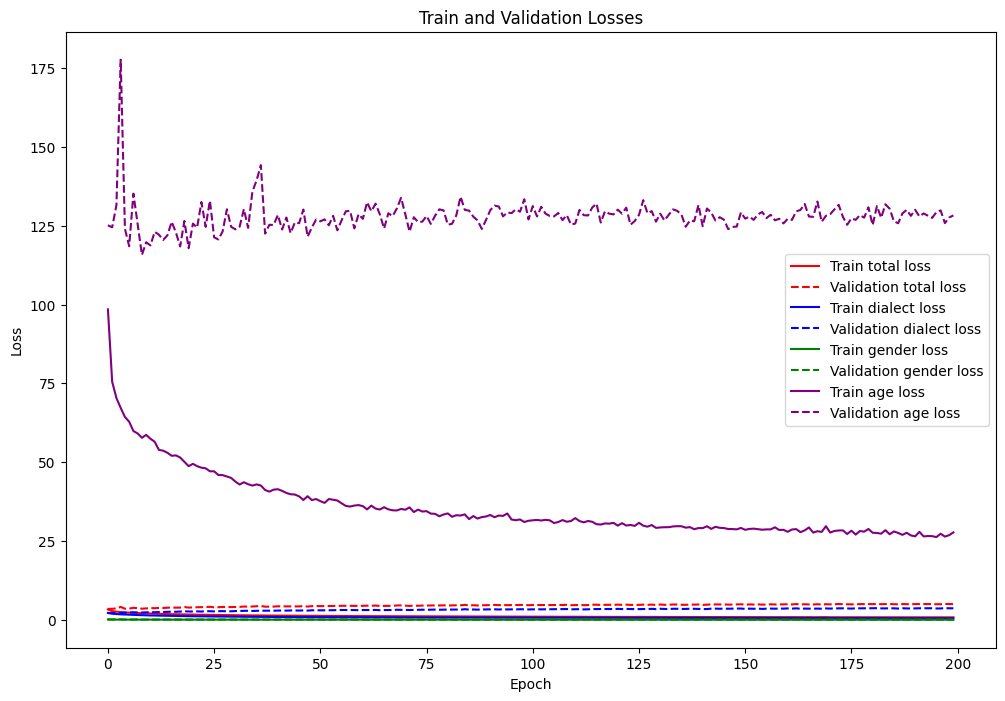

In [11]:
import matplotlib.pyplot as plt

colors = {"total":"r", "dialect": "b", "gender": "g", "age": "purple"}

plt.figure(figsize=(12, 8))
for task in ["total", "dialect", "gender", "age"]:
    plt.plot(train_losses[task], color=colors[task], label=f'Train {task} loss')
    plt.plot(val_losses[task], color=colors[task], linestyle='dashed', label=f'Validation {task} loss')

plt.title('Train and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


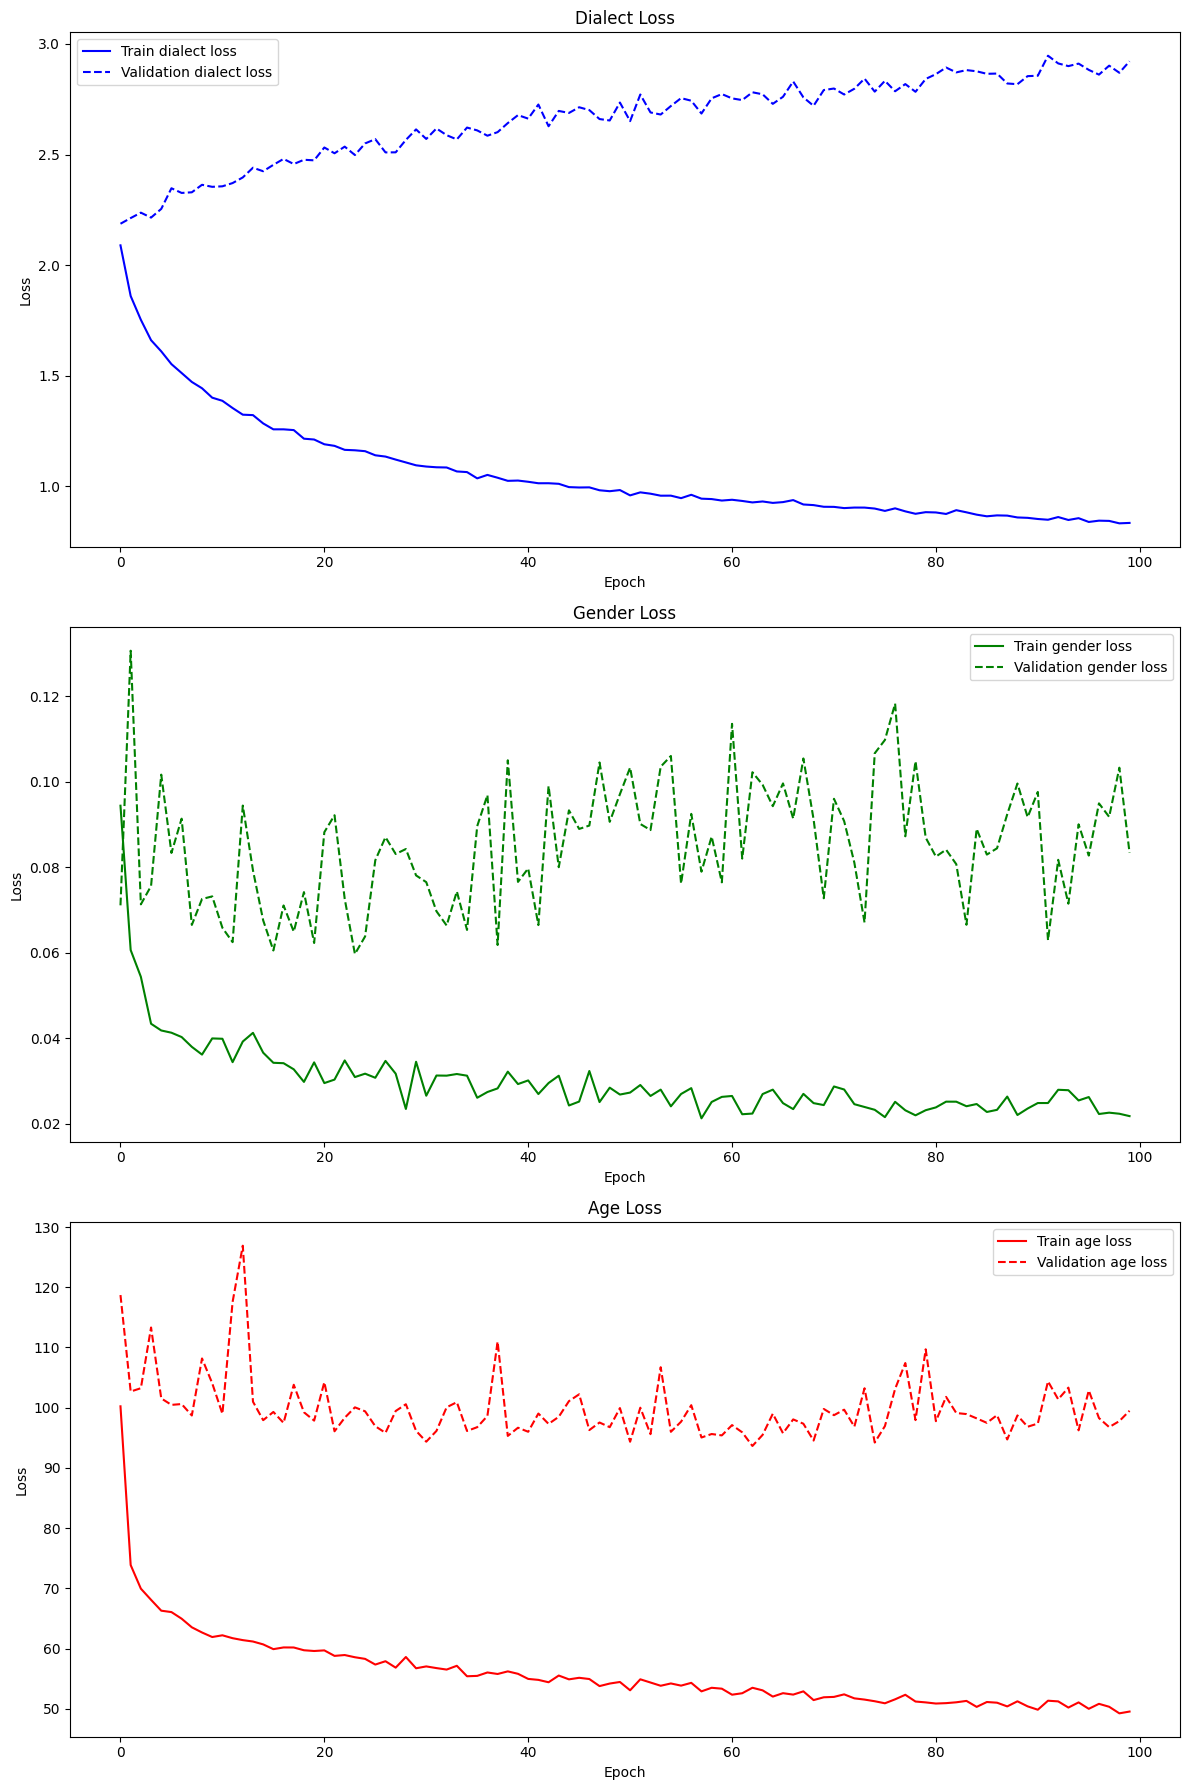

In [74]:
fig, axs = plt.subplots(3, figsize=(12, 18))

tasks = ["dialect", "gender", "age"]
colors = {"dialect": "b", "gender": "g", "age": "r"}

for i, task in enumerate(tasks):
    axs[i].plot(train_losses[task], color=colors[task], label=f'Train {task} loss')
    axs[i].plot(val_losses[task], color=colors[task], linestyle='dashed', label=f'Validation {task} loss')
    axs[i].set_title(f'{task.capitalize()} Loss')
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].legend()

plt.tight_layout()
plt.show()



In [12]:
# Load the saved model
model_path = 'MLP_model_multitask.pth'
model = MultiTaskMLP(input_dim=94, hidden_dim1=256, hidden_dim2=128)
model.load_state_dict(torch.load(model_path))
model = model.to(device)

def predict(model, loader):
    model.eval()
    
    all_dialect_preds = []
    all_gender_preds = []
    all_age_preds = []
    
    all_true_dialects = []
    all_true_genders = []
    all_true_ages = []
    
    with torch.no_grad():
        for features, _, gender, dialect, age in loader:
            
            features = features.to(device)
            true_dialects = (dialect - 1).to(device)
            true_genders = gender.to(device)
            true_ages = age.to(device)

            dialect_out, gender_out, age_out = model(features)
            
            dialect_preds = dialect_out.argmax(dim=1).flatten().numpy()
            gender_preds = gender_out.argmax(dim=1).flatten().numpy()
            age_preds = age_out.flatten().numpy()
            
            all_dialect_preds.extend(dialect_preds)
            all_gender_preds.extend(gender_preds)
            all_age_preds.extend(age_preds)

            all_true_dialects.extend(true_dialects.numpy())
            all_true_genders.extend(true_genders.numpy())
            all_true_ages.extend(true_ages.numpy())
    
    return all_dialect_preds, all_gender_preds, all_age_preds, all_true_dialects, all_true_genders, all_true_ages

# Apply the model to the test data
test_dialect_preds, test_gender_preds, test_age_preds, true_dialects, true_genders, true_ages = predict(model, test_loader)


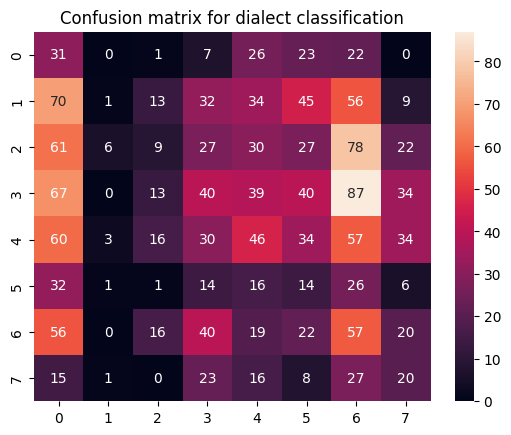

Dialect Accuracy: 0.12976190476190477
Dialect Precision: 0.14032250439905652
Dialect Recall: 0.12976190476190477
F1 score for each dialect class [0.12350598 0.00735294 0.05471125 0.15009381 0.18181818 0.08668731
 0.178125   0.15686275]
Accuracy for class 0: 0.28
Accuracy for class 1: 0.00
Accuracy for class 2: 0.03
Accuracy for class 3: 0.12
Accuracy for class 4: 0.16
Accuracy for class 5: 0.13
Accuracy for class 6: 0.25
Accuracy for class 7: 0.18


In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score,recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Confusion matrix for dialect
confusion_dialect = confusion_matrix(true_dialects, test_dialect_preds)
sns.heatmap(confusion_dialect, annot=True, fmt='d')
plt.title('Confusion matrix for dialect classification')
plt.show()


# Compute classification metrics for dialect
dialect_accuracy = accuracy_score(true_dialects, test_dialect_preds)
dialect_precision = precision_score(true_dialects, test_dialect_preds, average='weighted')
dialect_recall = recall_score(true_dialects, test_dialect_preds, average='weighted')
dialect_f1 = f1_score(true_dialects, test_dialect_preds, average='weighted')

print ('Dialect Accuracy:', dialect_accuracy)
print('Dialect Precision:', dialect_precision)
print('Dialect Recall:', dialect_recall)
print("F1 score for each dialect class", f1_score(true_dialects, test_dialect_preds, average=None))

# Compute class accuracy
class_accuracy = confusion_dialect.diagonal() / confusion_dialect.sum(axis=1)

# Print class accuracy
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for class {i}: {acc:.2f}")



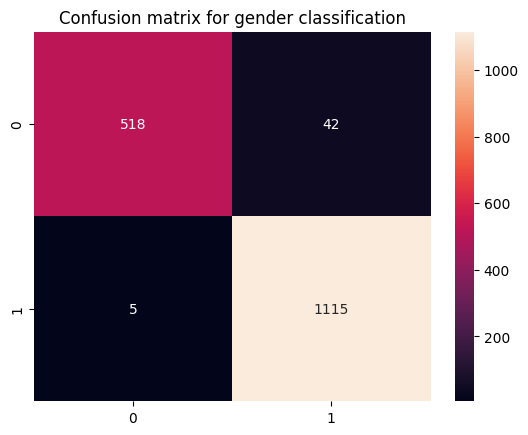

Gender Accuracy: 0.9720238095238095
Gender Precision: 0.9726127382689567
Gender Recall: 0.9720238095238095
F1 score for each gender class [0.95660203 0.97935881]


In [14]:


# Confusion matrix for gender
confusion_gender = confusion_matrix(true_genders, test_gender_preds)
sns.heatmap(confusion_gender, annot=True, fmt='d')
plt.title('Confusion matrix for gender classification')
plt.show()

# Compute classification metrics for gender
gender_accuracy = accuracy_score(true_genders, test_gender_preds)
gender_precision = precision_score(true_genders, test_gender_preds, average='weighted')
gender_recall = recall_score(true_genders, test_gender_preds, average='weighted')
gender_f1 = f1_score(true_genders, test_gender_preds, average=None)

print ('Gender Accuracy:', gender_accuracy)
print('Gender Precision:', gender_precision)
print('Gender Recall:', gender_recall)
print("F1 score for each gender class", gender_f1)

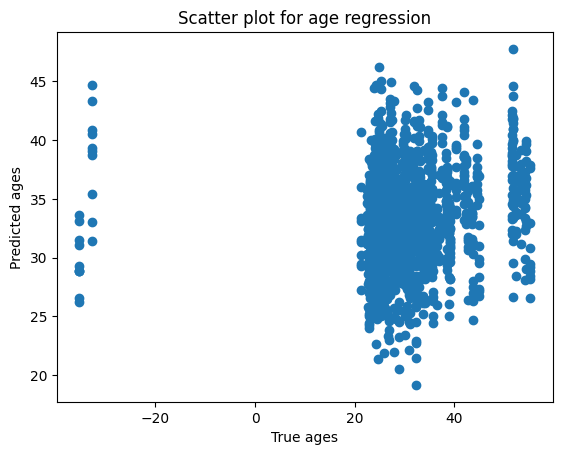

Age metrics:
  MSE: 126.16
  MAE: 7.71
  R2 Score: -0.20


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Scatter plot for age
plt.scatter(true_ages, test_age_preds)
plt.xlabel('True ages')
plt.ylabel('Predicted ages')
plt.title('Scatter plot for age regression')
plt.show()

mse = mean_squared_error(true_ages, test_age_preds)
mae = mean_absolute_error(true_ages, test_age_preds)
r2 = r2_score(true_ages, test_age_preds)

print("Age metrics:")
print(f"  MSE: {mse:.2f}")
print(f"  MAE: {mae:.2f}")
print(f"  R2 Score: {r2:.2f}")

# separate model for each task
# separate model for dialect prediction task

In [17]:

import torch
import torch.nn as nn
import copy
import time
from torch.optim import Adam
import torch.optim as optim
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2, num_classes, dropout_prob=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc4 = nn.Linear(hidden_dim2, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)
        #self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        #out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc4(out)
        return out
    
    
def train_MLP(model, train_loader, val_loader, criterion, optimizer, num_epochs):

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0.0
 
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        val_loss = 0.0
        val_correct =0.0
   
        # Training
        model.train()
        for features_train, _,_ , dialect_train,_ in train_loader:
            inputs= features_train
            targets= dialect_train -1
            inputs = inputs.to(device)
            targets = targets.to(device) 
            outputs = model(inputs) 
            loss = criterion(outputs, targets.long()) 
            pred_label = torch.argmax(outputs,dim=1)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()* inputs.size(0)
            train_correct += torch.sum(pred_label == targets)

        # Validation
        model.eval()
        
        with torch.no_grad():
            for features_val, _, _, dialect_val,_ in val_loader:
                inputs= features_val
                targets= dialect_val -1
                inputs = inputs.to(device)
                targets = targets.to(device)   
                outputs = model(inputs)
                loss = criterion(outputs, targets.long()) 
                pred_label = torch.argmax (outputs,dim=1)
               
                val_loss += loss.item() * inputs.size(0)
                val_correct += torch.sum(pred_label == targets)

        # Calculate metrics
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        
        #save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "single_task_dialect.pth")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        
       
        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

In [18]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=94, hidden_dim1=256, hidden_dim2=128, num_classes=8).to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 200
train_losses, val_losses, train_accs, val_accs = train_MLP(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/200: Train Loss: 1.8947, Train Acc: 0.2728, Val Loss: 2.2205, Val Acc: 0.1399
Epoch 2/200: Train Loss: 1.6097, Train Acc: 0.4029, Val Loss: 2.3325, Val Acc: 0.1548
Epoch 3/200: Train Loss: 1.4321, Train Acc: 0.4781, Val Loss: 2.4298, Val Acc: 0.1220
Epoch 4/200: Train Loss: 1.2985, Train Acc: 0.5338, Val Loss: 2.6096, Val Acc: 0.1190
Epoch 5/200: Train Loss: 1.2002, Train Acc: 0.5690, Val Loss: 2.5657, Val Acc: 0.1429
Epoch 6/200: Train Loss: 1.1264, Train Acc: 0.6038, Val Loss: 2.6653, Val Acc: 0.1250
Epoch 7/200: Train Loss: 1.0564, Train Acc: 0.6227, Val Loss: 2.7298, Val Acc: 0.1548
Epoch 8/200: Train Loss: 1.0117, Train Acc: 0.6393, Val Loss: 2.8280, Val Acc: 0.1310
Epoch 9/200: Train Loss: 0.9669, Train Acc: 0.6562, Val Loss: 2.8720, Val Acc: 0.1339
Epoch 10/200: Train Loss: 0.9231, Train Acc: 0.6739, Val Loss: 2.7751, Val Acc: 0.1399
Epoch 11/200: Train Loss: 0.8907, Train Acc: 0.6816, Val Loss: 3.0018, Val Acc: 0.1458
Epoch 12/200: Train Loss: 0.8573, Train Acc: 0.6951,

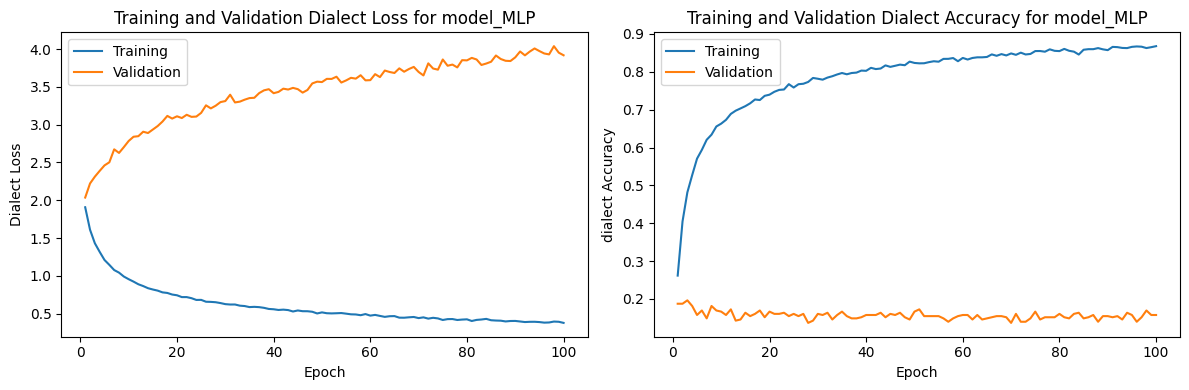

In [52]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Dialect Loss')
plt.title('Training and Validation Dialect Loss for model_MLP')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Training')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('dialect Accuracy')
plt.title('Training and Validation Dialect Accuracy for model_MLP')
plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

Dialect Accuracy for single-task learning: 0.15595238095238095
Dialect Precision for single-task learning: 0.1583093004040871
Dialect Recall for single-task learning: 0.15595238095238095
single-task learning  F1 score for each dialect class [0.0733945  0.06748466 0.15189873 0.24944321 0.14655172 0.04830918
 0.15609756 0.1322314 ]


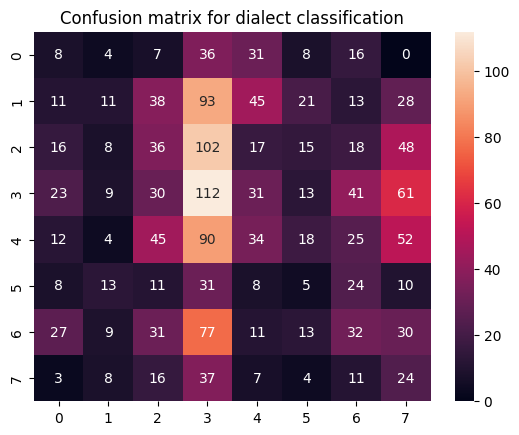

Accuracy for class 0: 0.07
Accuracy for class 1: 0.04
Accuracy for class 2: 0.14
Accuracy for class 3: 0.35
Accuracy for class 4: 0.12
Accuracy for class 5: 0.05
Accuracy for class 6: 0.14
Accuracy for class 7: 0.22


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score,recall_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load the saved parameters into the model
device= torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = MLP(input_dim=94, hidden_dim1=256,  hidden_dim2=128, num_classes=8).to(device)

model.load_state_dict(torch.load("single_task_dialect.pth"))



all_predictions = []
all_targets = []

model.eval()
# Iterate over the test DataLoader
        
with torch.no_grad():
   for features_test, _, _, dialect_test,_ in test_loader:
         inputs= features_test
         targets= dialect_test -1
         inputs = inputs.to(device)
         targets = targets.to(device)   
         outputs = model(inputs)
         pred_labels = torch.argmax(outputs, dim=1)
                
         all_predictions.extend(pred_labels.flatten().tolist())
         all_targets.extend(targets.flatten().tolist()) 


# Compute classification metrics for dialect
dialect_accuracy = accuracy_score(all_targets, all_predictions)
dialect_precision = precision_score(all_targets, all_predictions, average='weighted')
dialect_recall = recall_score(all_targets, all_predictions, average='weighted')
dialect_f1 = f1_score(all_targets, all_predictions, average='weighted')

print ('Dialect Accuracy for single-task learning:', dialect_accuracy)
print('Dialect Precision for single-task learning:', dialect_precision)
print('Dialect Recall for single-task learning:', dialect_recall)
print("single-task learning  F1 score for each dialect class", f1_score(all_targets, all_predictions, average=None))

# Compute the confusion matrix
confusion_dialect = confusion_matrix(all_targets, all_predictions)
sns.heatmap(confusion_dialect, annot=True, fmt='d')
plt.title('Confusion matrix for dialect classification')
plt.show()
# Compute class accuracy
class_accuracy = confusion_dialect.diagonal() / confusion_dialect.sum(axis=1)

# Print class accuracy
for i, acc in enumerate(class_accuracy):
    print(f"Accuracy for class {i}: {acc:.2f}")


# separate model for age prediction task

In [22]:
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_mae = []
    val_mae = []# mean absolute errorr
    train_r2 = []
    val_r2 = []

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_targets = []
        train_predictions = []
        val_targets = []
        val_predictions = []


        # Training
        model.train()
        for inputs,_, _,_, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.float())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_targets.extend(targets.tolist())
            train_predictions.extend(outputs.squeeze().tolist())

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, _, _,_, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets.float())

                val_loss += loss.item() * inputs.size(0)
                val_targets.extend(targets.tolist())
                val_predictions.extend(outputs.squeeze().tolist())

        # Calculate metrics
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        train_mae_score = mean_absolute_error(train_targets, train_predictions)
        val_mae_score = mean_absolute_error(val_targets, val_predictions)
        train_r2_score = r2_score(train_targets, train_predictions)
        val_r2_score = r2_score(val_targets, val_predictions)

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'MLP_model_for_age_1.pth')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_mae.append(train_mae_score)
        val_mae.append(val_mae_score)

        train_r2.append(train_r2_score)
        val_r2.append(val_r2_score)#

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train MAE: {train_mae_score:.4f}, Val MAE: {val_mae_score:.4f}, "
              f"Train R2: {train_r2_score:.4f}, Val R2: {val_r2_score:.4f}")

    return train_losses, val_losses, train_mae, val_mae, train_r2, val_r2

### If the absolute accuracy of the age prediction is crucial, then MAE is more appropriate, and smaller values are desired. 
# If you want to assess how well the model explains the variation in age, then R2 score is more suitable, and higher values indicate better performance.
### If the absolute accuracy of the age prediction is crucial, then MAE is more appropriate, and smaller values are desired. 
# If you want to assess how well the model explains the variation in age, then R2 score is more suitable, and higher values indicate better performance.

In [23]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=94, hidden_dim1=256, hidden_dim2=128,num_classes=1).to(device)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.MSELoss()

num_epochs = 200
train_losses, val_losses, train_mae, val_mae, train_r2, val_r2 = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/200: Train Loss: 93.2968, Val Loss: 134.7682, Train MAE: 6.9154, Val MAE: 8.1167, Train R2: -0.3496, Val R2: -0.1973
Epoch 2/200: Train Loss: 72.3811, Val Loss: 148.9092, Train MAE: 6.0680, Val MAE: 8.6603, Train R2: -0.0470, Val R2: -0.3230
Epoch 3/200: Train Loss: 67.0500, Val Loss: 124.1061, Train MAE: 5.8076, Val MAE: 7.3265, Train R2: 0.0301, Val R2: -0.1026
Epoch 4/200: Train Loss: 64.1374, Val Loss: 142.0616, Train MAE: 5.6300, Val MAE: 8.6400, Train R2: 0.0722, Val R2: -0.2621
Epoch 5/200: Train Loss: 61.6057, Val Loss: 119.8115, Train MAE: 5.5666, Val MAE: 7.0334, Train R2: 0.1088, Val R2: -0.0644
Epoch 6/200: Train Loss: 60.6431, Val Loss: 121.7630, Train MAE: 5.5153, Val MAE: 7.1826, Train R2: 0.1228, Val R2: -0.0818
Epoch 7/200: Train Loss: 57.8808, Val Loss: 133.6590, Train MAE: 5.3998, Val MAE: 7.1673, Train R2: 0.1627, Val R2: -0.1875
Epoch 8/200: Train Loss: 55.9019, Val Loss: 128.3469, Train MAE: 5.3268, Val MAE: 6.8985, Train R2: 0.1913, Val R2: -0.1403
Epoch 

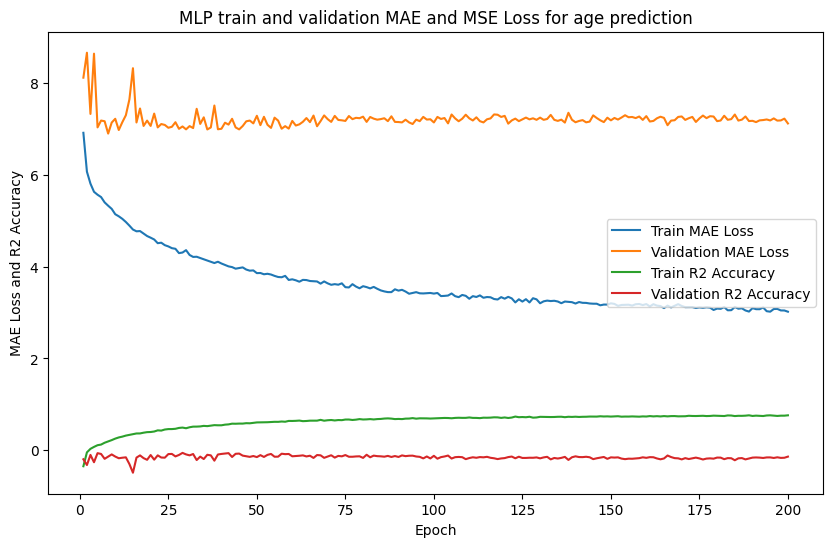

In [24]:
import matplotlib.pyplot as plt

# Plot the training and validation loss and MAE loss

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_mae, label='Train MAE Loss')
plt.plot(range(1, num_epochs + 1), val_mae, label='Validation MAE Loss')
plt.plot (range(1, num_epochs + 1), train_r2, label='Train R2 Accuracy')
plt.plot(range(1, num_epochs + 1), val_r2, label='Validation R2 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss and R2 Accuracy')
plt.title('MLP train and validation MAE and MSE Loss for age prediction')
plt.legend()
plt.show()

In [28]:
import numpy as np


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the stored model
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=94, hidden_dim1=256, hidden_dim2=128,num_classes=1).to(device)
model.load_state_dict(torch.load('MLP_model_for_age_1.pth'))
model.eval()

# Create an empty list to store the predictions and targets
all_predictions = []
all_targets = []

# Iterate over the test DataLoader
for inputs, _, _, _, targets in test_loader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    pred_labels = outputs.squeeze().tolist()

    all_predictions.extend(pred_labels)
    all_targets.extend(targets.tolist())

# Compute metrics
mse = mean_squared_error(all_targets, all_predictions)
rmse= np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

# Print metrics
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")


RMSE: 10.5756
MAE: 6.6625
R2 Score: -0.0668


# separate model for gender prediction task

In [61]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
 
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        val_loss = 0.0
        val_correct =0.0
   
        # Training
        model.train()
        for inputs,_,targets,_ ,_ in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device) 
            outputs = model(inputs) 
            loss = criterion(outputs, targets.long()) 
            pred_label = torch.argmax(outputs,dim=1)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()* inputs.size(0)
            train_correct += torch.sum(pred_label == targets)

        # Validation
        model.eval()
        
        with torch.no_grad():
            for inputs,_,targets,_ ,_  in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)   
                outputs = model(inputs)
                loss = criterion(outputs, targets.long()) 
                pred_label = torch.argmax (outputs,dim=1)
               
                val_loss += loss.item() * inputs.size(0)
                val_correct += torch.sum(pred_label == targets)

        # Calculate metrics
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        
        #save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_MLP_model_gender.pth')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        
       
        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, train_accs, val_accs

In [63]:

device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=40, hidden_dim1=256, hidden_dim2=128,num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, weight_decay=1e-4)

num_epochs = 100
train_losses, val_losses, train_accs, val_accs = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/100: Train Loss: 0.0434, Train Acc: 0.9857, Val Loss: 0.0388, Val Acc: 0.9881
Epoch 2/100: Train Loss: 0.0186, Train Acc: 0.9939, Val Loss: 0.0451, Val Acc: 0.9821
Epoch 3/100: Train Loss: 0.0110, Train Acc: 0.9966, Val Loss: 0.0454, Val Acc: 0.9851
Epoch 4/100: Train Loss: 0.0086, Train Acc: 0.9969, Val Loss: 0.0479, Val Acc: 0.9851
Epoch 5/100: Train Loss: 0.0104, Train Acc: 0.9960, Val Loss: 0.0384, Val Acc: 0.9851
Epoch 6/100: Train Loss: 0.0080, Train Acc: 0.9974, Val Loss: 0.0641, Val Acc: 0.9851
Epoch 7/100: Train Loss: 0.0110, Train Acc: 0.9963, Val Loss: 0.0447, Val Acc: 0.9851
Epoch 8/100: Train Loss: 0.0081, Train Acc: 0.9977, Val Loss: 0.0546, Val Acc: 0.9881
Epoch 9/100: Train Loss: 0.0086, Train Acc: 0.9964, Val Loss: 0.0346, Val Acc: 0.9911
Epoch 10/100: Train Loss: 0.0111, Train Acc: 0.9969, Val Loss: 0.0392, Val Acc: 0.9881
Epoch 11/100: Train Loss: 0.0068, Train Acc: 0.9980, Val Loss: 0.0337, Val Acc: 0.9911
Epoch 12/100: Train Loss: 0.0063, Train Acc: 0.9975,

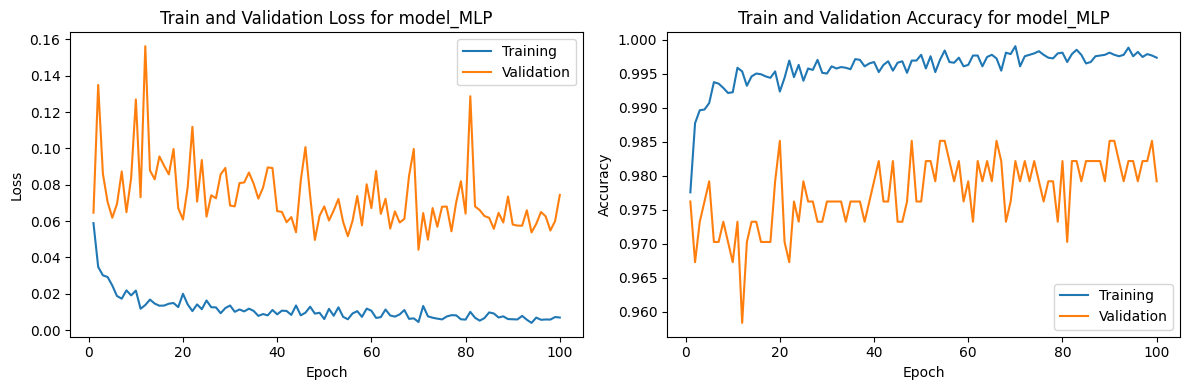

In [45]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss for model_MLP')
plt.legend()
# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Training')
plt.plot(range(1, num_epochs + 1), val_accs, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy for model_MLP')
plt.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


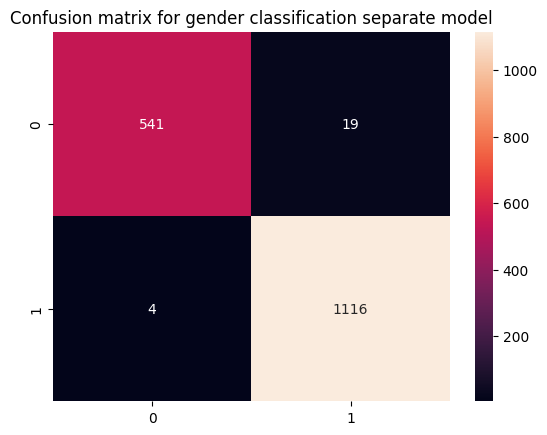

Gender Accuracy: 0.9863095238095239
Gender Precision: 0.9863934580824205
Gender Recall: 0.9863095238095239
F1 score for each gender class 0.9862621357599838


In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load the saved parameters into the model
device= torch.device('mps' if torch.cuda.is_available() else 'cpu')
model = MLP(input_dim=40, hidden_dim1=256, hidden_dim2=128, num_classes=2).to(device)
model.load_state_dict(torch.load('best_MLP_model_gender.pth'))


model.eval()
# Iterate over the test DataLoader

all_predictions = []
all_targets = []
        
with torch.no_grad():
    for inputs,_,targets,_ ,_ in test_loader:
        encoder = LabelEncoder() 
        inputs = inputs.to(device)
        targets = encoder.fit_transform(targets)
        targets = torch.tensor(targets).to(device)  
        outputs = model(inputs)
        pred_labels = torch.argmax (outputs,dim=1)
                
        all_predictions.extend(pred_labels.flatten().tolist())
        all_targets.extend(targets.flatten().tolist()) 
        
# Confusion matrix for gender
confusion_gender = confusion_matrix(all_targets, all_predictions)
sns.heatmap(confusion_gender, annot=True, fmt='d')
plt.title('Confusion matrix for gender classification separate model')
plt.show()

# Compute classification metrics for gender
gender_accuracy = accuracy_score(all_targets, all_predictions)
gender_precision = precision_score(all_targets, all_predictions, average='weighted')
gender_recall = recall_score(all_targets, all_predictions, average='weighted')
gender_f1 = f1_score(all_targets, all_predictions, average='weighted')

print ('Gender Accuracy:', gender_accuracy)
print('Gender Precision:', gender_precision)
print('Gender Recall:', gender_recall)
print("F1 score for each gender class", gender_f1)